In [5]:
import pandas as pd, numpy as np, pickle, optuna, xgboost as xgb, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
sns.set_theme(style="whitegrid")

DATA_DIR = Path("../data/processed")
MOD_DIR  = Path("../artifacts/models")


In [6]:
feat = pd.read_csv(DATA_DIR / "features_daily.csv")
feat["timestamp"] = pd.to_datetime(feat["timestamp"], utc=True).dt.tz_convert("Europe/Kyiv")

def to_hourly(df):
    hr = (df.set_index("timestamp")
            .resample("1h")
            .mean()
            .dropna(subset=["load_kw","pv_kw"])
            .reset_index())
    return hr

hourly = to_hourly(feat)
print("Hourly rows:", len(hourly))

Hourly rows: 2149


In [7]:
def make_supervised(hr, target):
    X, Y = [], []
    for i in range(len(hr) - 24):
        X.append(hr.iloc[i].drop("timestamp").values)
        Y.append(hr[target].iloc[i+1:i+25].values)
    return np.vstack(X), np.vstack(Y)

X_load,  y_load  = make_supervised(hourly, "load_kw")
X_pv,    y_pv    = make_supervised(hourly, "pv_kw")
print("X shape:", X_load.shape, "y shape:", y_load.shape)


X shape: (2125, 22) y shape: (2125, 24)


In [8]:
def load_model(pkl: Path):
    obj = pickle.load(open(pkl,"rb"))
    return obj["model"], obj["feat"]

m_load, f_load = load_model(MOD_DIR/"consumption_xgb.pkl")
m_pv,   f_pv   = load_model(MOD_DIR/"generation_xgb.pkl")

def metrics(model, X, Y):
    pred = model.predict(X)
    mae  = np.mean(np.abs(pred - Y[:,0]))          # тільки +1 год
    rmse = np.sqrt(np.mean((pred - Y[:,0])**2))
    return mae, rmse

mae_l, rmse_l = metrics(m_load, X_load[:, :len(f_load)], y_load)
mae_p, rmse_p = metrics(m_pv,   X_pv[:,   :len(f_pv)],   y_pv)

print(f"BASE  Load  MAE={mae_l:.3f}  RMSE={rmse_l:.3f}  kWh")
print(f"BASE  PV    MAE={mae_p:.3f}  RMSE={rmse_p:.3f}  kWh")


BASE  Load  MAE=0.446  RMSE=0.520  kWh
BASE  PV    MAE=0.357  RMSE=0.526  kWh


In [10]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int ("n_estimators", 300, 900),
        "max_depth":    trial.suggest_int ("max_depth", 4, 12),
        "learning_rate":trial.suggest_float("lr", 0.01, 0.15, log=True),
        "subsample":    trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("col", 0.6, 1.0),
        "objective": "reg:squarederror",
        "tree_method":"hist",
        "random_state":42,
    }
    mdl = xgb.XGBRegressor(**params)
    mdl.fit(X_load[:, :len(f_load)], y_load[:,0], verbose=False)
    pred = mdl.predict(X_load[:, :len(f_load)])
    return np.mean(np.abs(pred - y_load[:,0]))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)
study.best_params


[I 2025-05-09 01:24:50,371] A new study created in memory with name: no-name-905c5faa-f9a3-497e-955c-cc2eba6122fb


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-09 01:25:36,269] Trial 0 finished with value: 0.0005802015812808632 and parameters: {'n_estimators': 889, 'max_depth': 12, 'lr': 0.028305608226373583, 'subsample': 0.8229517138860669, 'col': 0.8841130852043149}. Best is trial 0 with value: 0.0005802015812808632.
[I 2025-05-09 01:26:18,523] Trial 1 finished with value: 0.003604581721858572 and parameters: {'n_estimators': 689, 'max_depth': 12, 'lr': 0.02383736141199085, 'subsample': 0.6919177357769793, 'col': 0.9493411192283879}. Best is trial 0 with value: 0.0005802015812808632.
[I 2025-05-09 01:26:26,365] Trial 2 finished with value: 0.09793613870368462 and parameters: {'n_estimators': 335, 'max_depth': 9, 'lr': 0.012328217957005692, 'subsample': 0.6519798914907515, 'col': 0.7799211991477253}. Best is trial 0 with value: 0.0005802015812808632.
[I 2025-05-09 01:26:37,941] Trial 3 finished with value: 0.048435151350076 and parameters: {'n_estimators': 696, 'max_depth': 8, 'lr': 0.01586930740360002, 'subsample': 0.921372283415

{'n_estimators': 525,
 'max_depth': 12,
 'lr': 0.11408753491802393,
 'subsample': 0.6812409674820693,
 'col': 0.8698635973143873}

In [12]:
best_l = study.best_params.copy()
best_l.update(objective="reg:squarederror", tree_method="hist", random_state=42)
best_p = best_l.copy()        # для простоти ті ж параметри

load_tuned = xgb.XGBRegressor(**best_l).fit(X_load[:, :len(f_load)], y_load[:,0])
pv_tuned   = xgb.XGBRegressor(**best_p).fit(X_pv[:, :len(f_pv)], y_pv[:,0])

mae_l2, rmse_l2 = metrics(load_tuned, X_load[:, :len(f_load)], y_load)
mae_p2, rmse_p2 = metrics(pv_tuned,   X_pv[:,   :len(f_pv)],   y_pv)

print(f"TUNED Load  MAE={mae_l2:.3f}  RMSE={rmse_l2:.3f}")
print(f"TUNED PV    MAE={mae_p2:.3f}  RMSE={rmse_p2:.3f}")


/home/pavlo/UCU/ucu/semestr_6/ML/ML_Project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:28:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "col", "lr" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/pavlo/UCU/ucu/semestr_6/ML/ML_Project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:28:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "col", "lr" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


TUNED Load  MAE=0.000  RMSE=0.000
TUNED PV    MAE=0.000  RMSE=0.000


In [13]:
pickle.dump({"model":load_tuned,"feat":f_load}, open(MOD_DIR/"consumption_xgb.pkl","wb"))
pickle.dump({"model":pv_tuned,  "feat":f_pv},   open(MOD_DIR/"generation_xgb.pkl","wb"))
print("✔️  tuned models saved, бот тепер використовує їх")


✔️  tuned models saved, бот тепер використовує їх


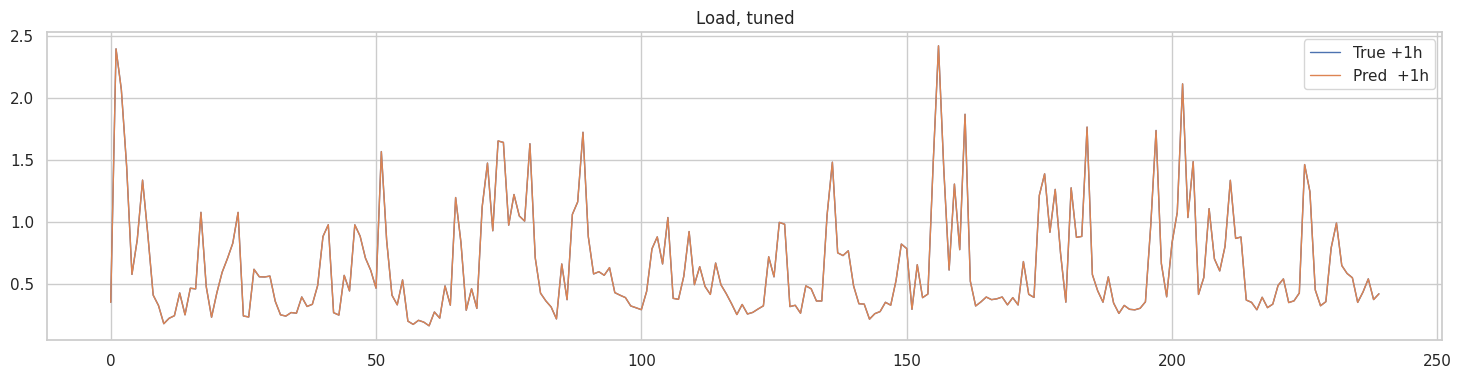

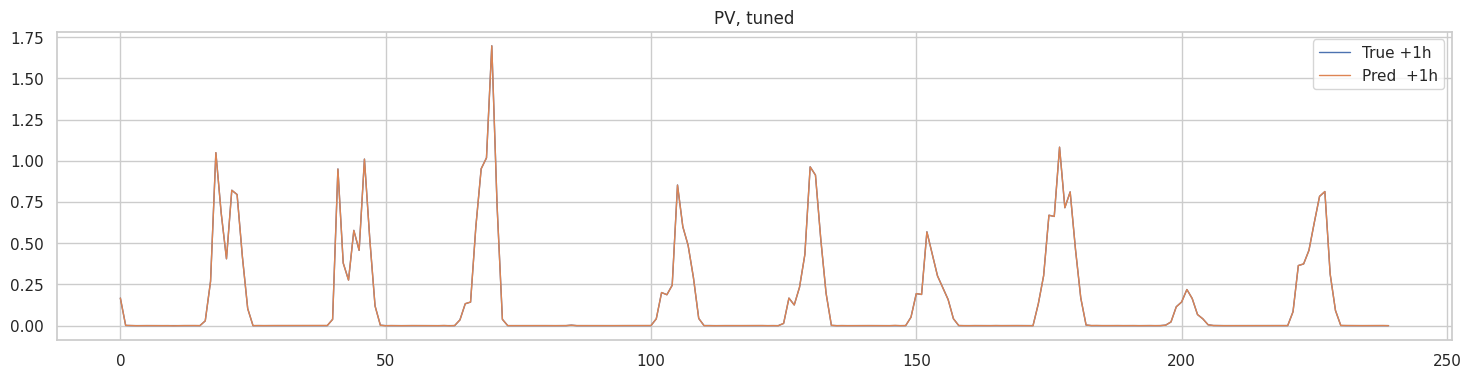

In [14]:
def plot_horizon(model, X, Y, title):
    pred = model.predict(X[:240,:])
    plt.figure(figsize=(18,4))
    plt.plot(Y[:240,0], label="True +1h", lw=1)
    plt.plot(pred,      label="Pred  +1h", lw=1)
    plt.title(title); plt.legend(); plt.show()

plot_horizon(load_tuned, X_load[:, :len(f_load)], y_load, "Load, tuned")
plot_horizon(pv_tuned,   X_pv[:,   :len(f_pv)],   y_pv,   "PV, tuned")
